In [23]:
import pandas as pd
import plotly
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import holidays
import yaml
import optuna
import json
import datetime
import logging

from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.serialize import model_to_json
from sklearn.model_selection import ParameterGrid
from tqdm import tqdm

import sys
import os

config_path = r'../config/params.yml'
config = yaml.load(open(config_path), Loader=yaml.FullLoader)

model_path = config['train']['model_path']
params_path = config['train']['params_path']
data_path = config['train']['data_path']
backend_path = config['train']["backend_path"]
sys.path.append(backend_path)
from get_metrics import get_metrics

In [24]:
# Чтение DataFrame df в файл data/df.csv
df = pd.read_csv(f'{data_path}/df.csv')

# Чтение DataFrame df_train в файл data/df_train.csv
df_train = pd.read_csv(f'{data_path}/df_train.csv')

# Чтение DataFrame df_test в файл data/df_test.csv
df_test = pd.read_csv(f'{data_path}/df_test.csv')

In [25]:
# Преобразование столбца ds в формат datetime
df['ds'] = pd.to_datetime(df['ds'], format='%Y-%m-%d', dayfirst=True)
df_train['ds'] = pd.to_datetime(df_train['ds'], format='%Y-%m-%d', dayfirst=True)
df_test['ds'] = pd.to_datetime(df_test['ds'], format='%Y-%m-%d', dayfirst=True)

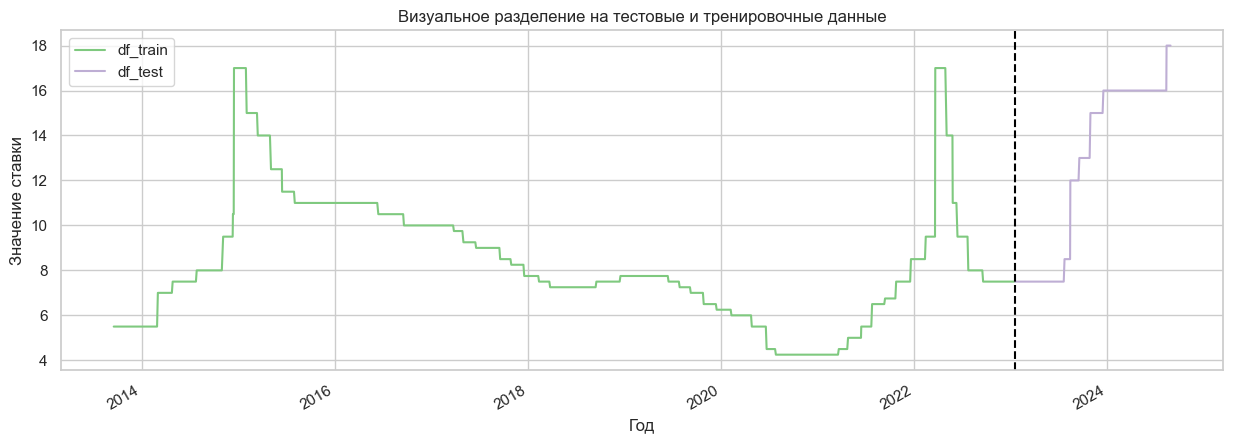

In [26]:
# Отображаем график с разделением train, test для наглядности
fig, ax = plt.subplots(figsize = (10, 5))

sns.set_theme(style="whitegrid", palette="Accent")

fig.set_figheight(5)
fig.set_figwidth(15)
df_train.set_index('ds').plot(ax=ax, label= 'train', title='Визуальное разделение на тестовые и тренировочные данные')
df_test.set_index('ds').plot(ax=ax, label='test')
ax.axvline(df_train['ds'][-1:].values, ls='--', color='black')
ax.legend(['df_train', 'df_test'])
ax.set_ylabel('Значение ставки')
ax.set_xlabel('Год')
plt.show()

In [27]:
# Период, который надо отрезать и предсказать (проверка модели)
pred_days = int(df.shape[0]*config['parcing']['pred_days'])

# Baseline Prophet on df_train для проверки модели

In [28]:
def train_model(df, **kwargs):
    """
    Обучение модели Prophet на данных.

    Аргументы:
        pandas.DataFrame: Данные для обучения с datetime и курсами.
        **kwargs: Параметры для модели Prophet.
    Возвращает: 
        Обученная модель.
    """
    model = Prophet(**kwargs)
    model.fit(df)
    return model

In [29]:
# Обучение модели на train
model_baseline = train_model(df_train)

02:45:48 - cmdstanpy - INFO - Chain [1] start processing
02:45:49 - cmdstanpy - INFO - Chain [1] done processing


In [30]:
# Создание df с прогнозом
future = model_baseline.make_future_dataframe(periods=pred_days, freq='D')
forecast = model_baseline.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2726,2024-02-26,14.003743,11.814384,16.168476
2727,2024-02-27,14.051247,11.776367,16.280569
2728,2024-02-28,14.097721,12.074238,16.364287
2729,2024-02-29,14.103376,11.759626,16.307094
2730,2024-03-01,14.127155,12.073336,16.328263


c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


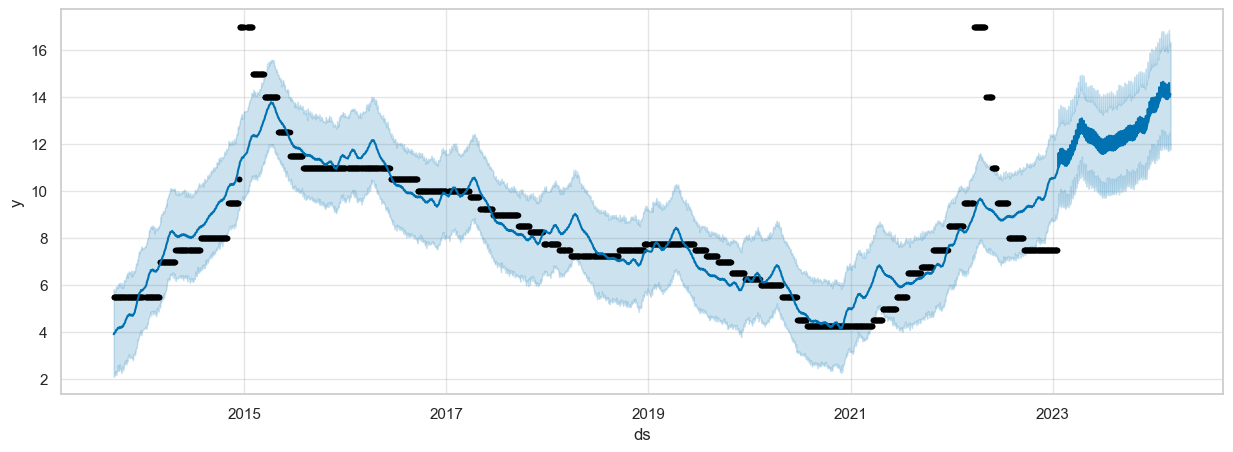

In [31]:
# Смотрим график прогноза
fig, ax = plt.subplots(1)
fig.set_figheight(5)
fig.set_figwidth(15)
fig = model_baseline.plot(forecast,ax=ax)
plt.show()

c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series cont

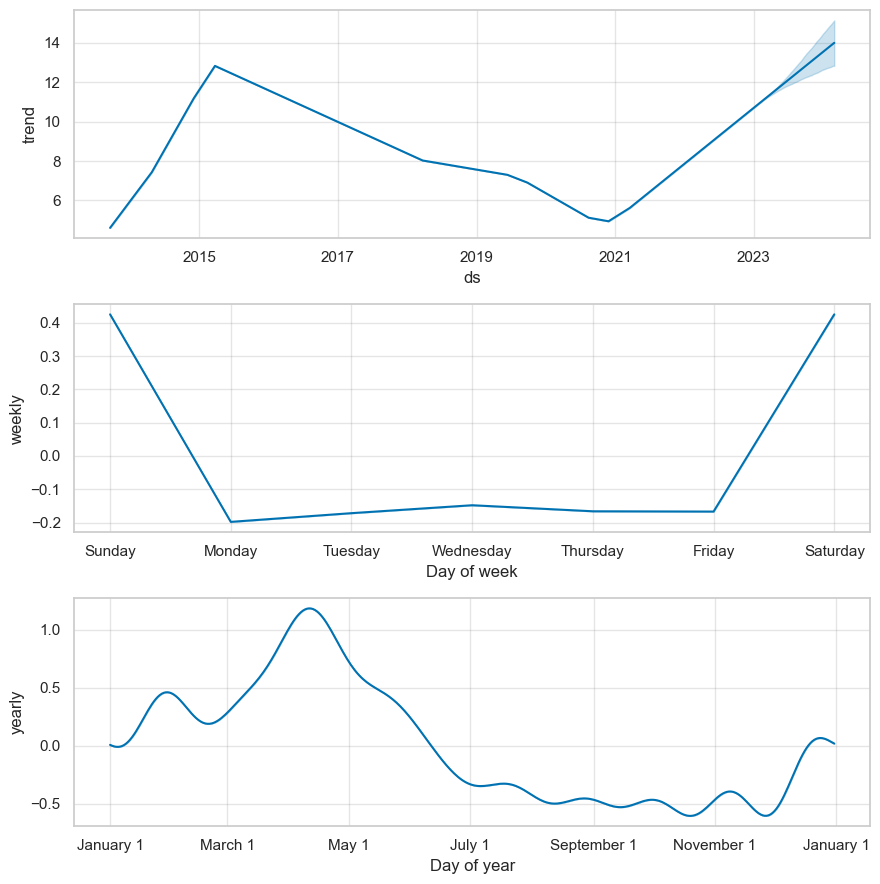

In [32]:
# Смотрим тренд, годовые и сезонные признаки
fig = model_baseline.plot_components(forecast)
plt.show()

## Сравнение фактов и прогнозов

In [33]:
# Создание df с прогнозом
df_test_forecast = model_baseline.predict(df_test)
df_test_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
404,2024-08-22,14.723826,11.706386,17.631712
405,2024-08-23,14.734527,11.866578,17.555455
406,2024-08-26,14.734003,11.927866,17.446668
407,2024-08-27,14.768454,11.820740,17.339313
408,2024-08-28,14.799520,12.001402,17.520364


c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


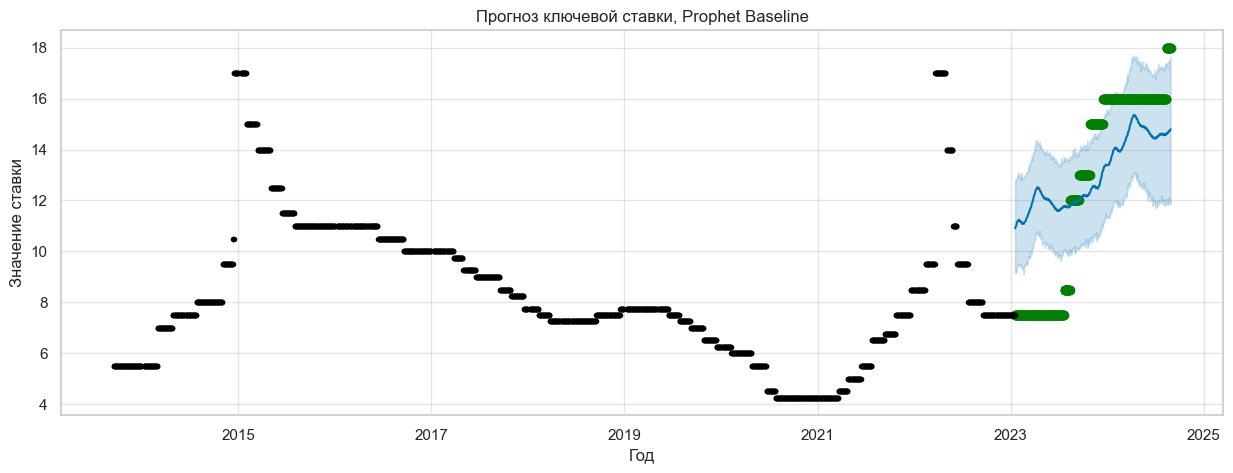

In [34]:
# Смотрим совпадение фактического курса с предсказанным курсом prophet baseline обученным на train
fig, ax = plt.subplots(figsize= (10, 5))

fig.set_figheight(5)
fig.set_figwidth(15)
predict = model_baseline.predict(df_test)
fig = model_baseline.plot(predict, ax=ax)
ax.scatter(df_test.ds, df_test['y'], color = 'g')
ax.set_title('Прогноз ключевой ставки, Prophet Baseline')
ax.set_ylabel('Значение ставки')
ax.set_xlabel('Год')
plt.show()

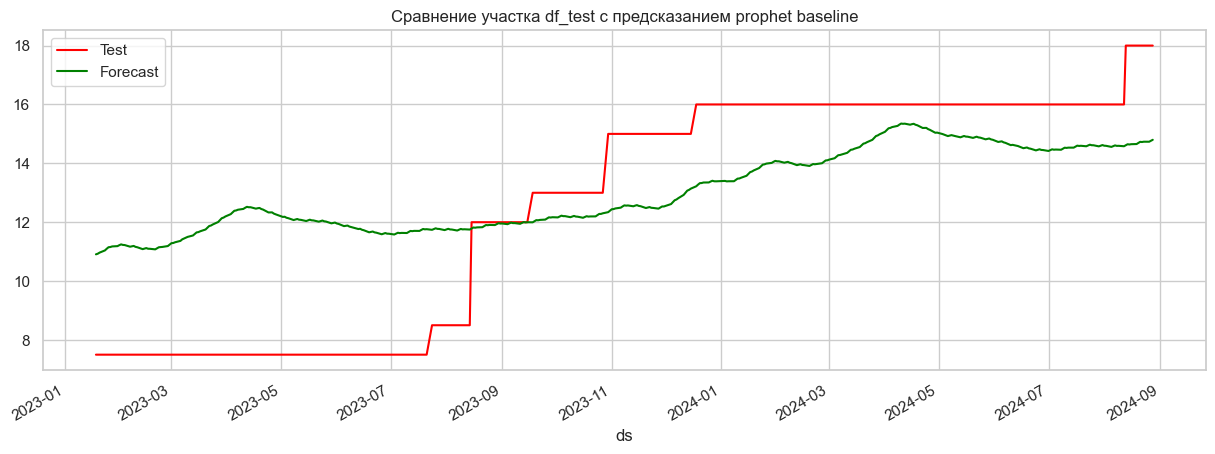

In [35]:
# Сравнение участка df_test с предсказанием prophet baseline
fig, ax = plt.subplots(figsize=(14,5))
fig.set_figheight(5)
fig.set_figwidth(15)
df_test.plot(kind='line',x='ds', y='y', color='red', label='Test', ax=ax)
df_test_forecast.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)
plt.title('Сравнение участка df_test с предсказанием prophet baseline')
plt.show()

In [36]:
# Просмотр метрик модели обученной на train
metrics = get_metrics(y_test=df_test['y'], y_pred=df_test_forecast['yhat'], name='Prophet_baseline')
metrics

,model,MAE,MAPE_%,MSE,RMSE
0,Prophet_baseline,2.448841,0.255418,8.082589,2.842989


Из приведенного выше графика мы видим, что существует разрыв в прогнозах и фактических данных. Поэтому нам нужно оптимизировать модель, добавив другие параметры, напрмиер, такие как праздники

# Prophet with holidays

In [37]:
# Создаем df праздников в РФ начиная с 2013 по сегодня
holiday = pd.DataFrame([])
for date, name in sorted(holidays.Russia(years=[2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024]).items()):
    new_row = pd.DataFrame({'ds': date, 'holiday': "RU-Holidays"}, index=[0])
    holiday = pd.concat([holiday, new_row], ignore_index=True)  

holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')

C:\Users\myxa-\AppData\Local\Temp\ipykernel_20492\3236026523.py:7: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')


In [38]:
# Тренировка модели с праздниками
model_with_holidays = train_model(df_train, holidays=holiday)

02:45:52 - cmdstanpy - INFO - Chain [1] start processing
02:45:52 - cmdstanpy - INFO - Chain [1] done processing


In [39]:
# Создание df с прогнозом
future = model_with_holidays.make_future_dataframe(periods=pred_days, freq='D')
forecast = model_with_holidays.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2726,2024-02-26,14.027196,11.720253,16.183890
2727,2024-02-27,14.070083,11.915392,16.393463
2728,2024-02-28,14.118612,11.913074,16.287435
2729,2024-02-29,14.116524,12.041774,16.323335
2730,2024-03-01,14.141921,11.845161,16.449295


c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


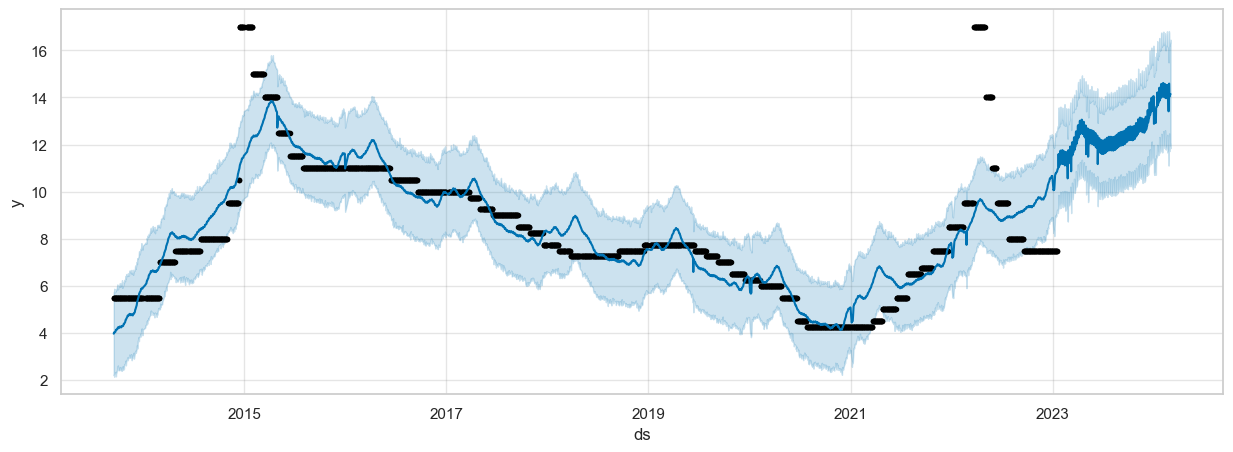

In [40]:
# Смотрим график прогноза с праздниками
fig, ax = plt.subplots(1)
fig.set_figheight(5)
fig.set_figwidth(15)
fig = model_with_holidays.plot(forecast,ax=ax)
plt.show()

c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series cont

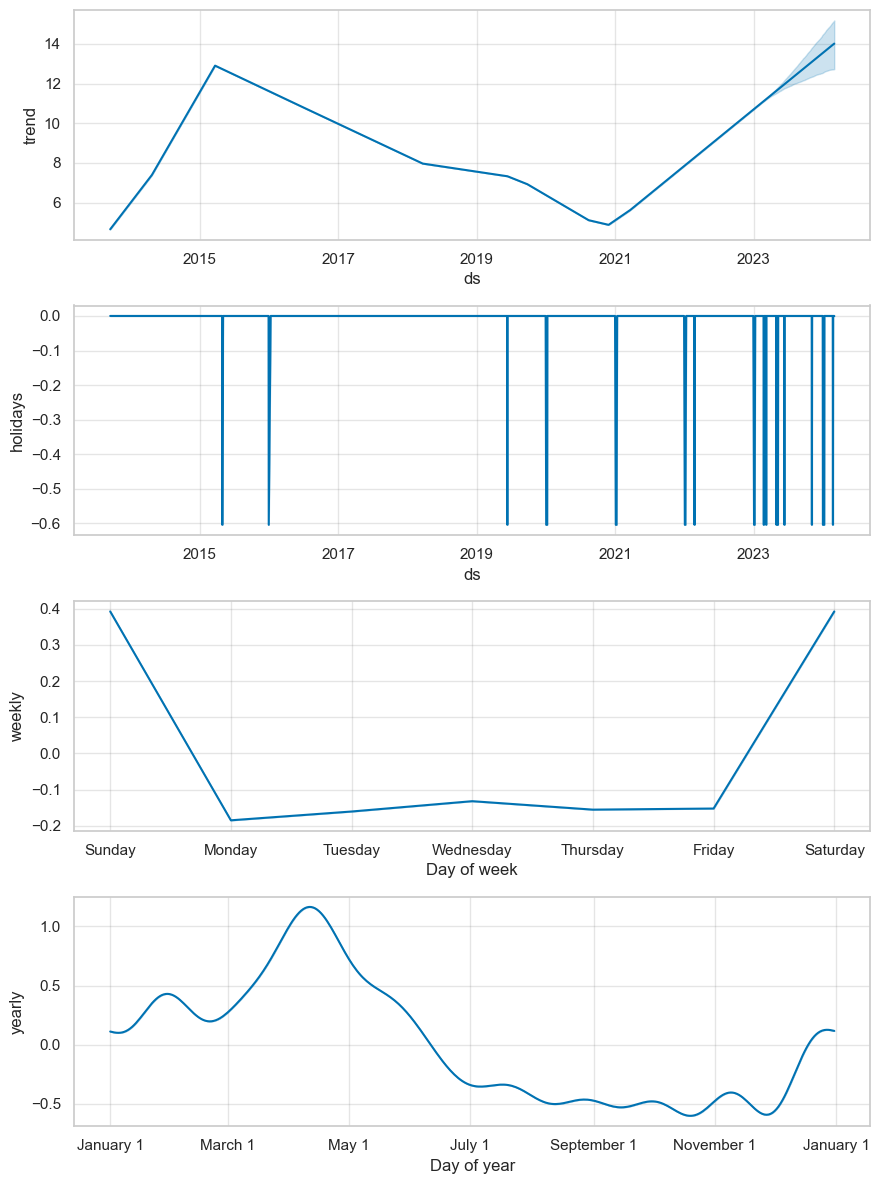

In [41]:
# Смотрим тренд, годовые и сезонные признаки обученной модели с праздниками
fig = model_with_holidays.plot_components(forecast)
plt.show()

## Сравнение фактов и прогнозов

In [42]:
# Создание df с прогнозом
df_test_forecast_holiday = model_with_holidays.predict(df_test)
df_test_forecast_holiday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
404,2024-08-22,14.746659,11.976001,17.516461
405,2024-08-23,14.760841,12.141452,17.494668
406,2024-08-26,14.757997,12.113624,17.473620
407,2024-08-27,14.790622,11.960958,17.619295
408,2024-08-28,14.826602,11.983806,17.547387


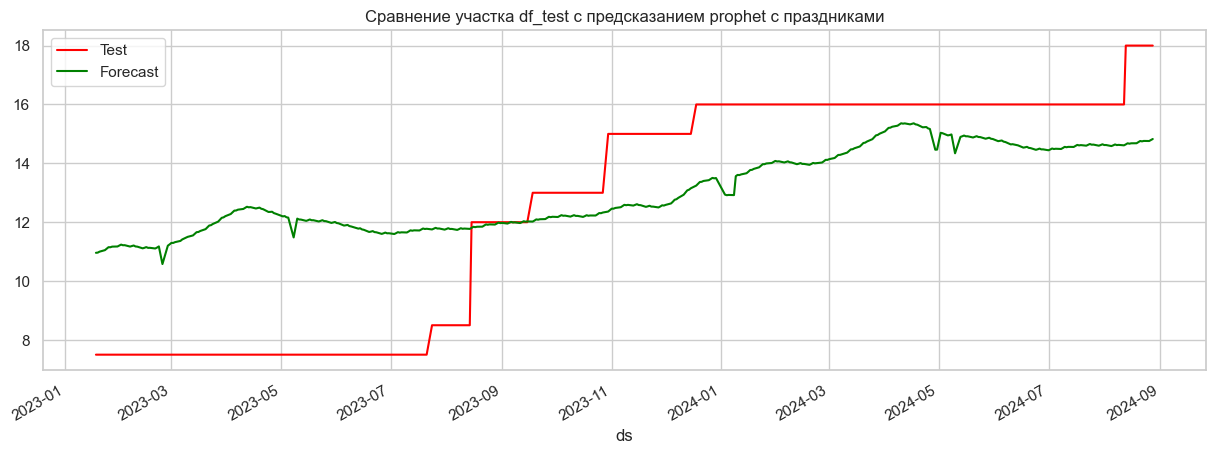

In [43]:
# Сравнение участка df_test с предсказанием prophet_with_holidays
fig, ax = plt.subplots(figsize=(14,5))
fig.set_figheight(5)
fig.set_figwidth(15)
df_test.plot(kind='line',x='ds', y='y', color='red', label='Test', ax=ax)
df_test_forecast_holiday.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)
plt.title('Сравнение участка df_test с предсказанием prophet с праздниками')
plt.show()

In [44]:
# Сравниваем метрики после добавления в модель праздников 
metrics = pd.concat([metrics, get_metrics(y_test=df_test['y'], y_pred=df_test_forecast_holiday['yhat'], name='Prophet_with_holidays')])
metrics

,model,MAE,MAPE_%,MSE,RMSE
0,Prophet_baseline,2.448841,0.255418,8.082589,2.842989
0,Prophet_with_holidays,2.443749,0.255147,8.078405,2.842253


Из метрик и графиков видим, что модель с праздниками показывает результаты немного изменились.

# Тюнинг тест модели

In [47]:
# Определите целевую функцию для оптимизации
def objective(trial):
    global best_score
    # Гиперпараметры для настройки
    changepoint_prior_scale = trial.suggest_float('changepoint_prior_scale', 0.001, 0.5)
    seasonality_prior_scale = trial.suggest_float('seasonality_prior_scale', 0.01, 10)
    holidays_prior_scale = trial.suggest_float('holidays_prior_scale', 0.01, 10)
    seasonality_mode = trial.suggest_categorical('seasonality_mode', ['additive', 'multiplicative'])

    # Создайте модель Prophet с гиперпараметрами
    model = Prophet(changepoint_prior_scale=changepoint_prior_scale,
                    seasonality_prior_scale=seasonality_prior_scale,
                    holidays_prior_scale=holidays_prior_scale,
                    seasonality_mode=seasonality_mode,
                    )

    # Обучите модель
    model.fit(df_train)

    # Выполните кросс-валидацию
    cv_results = cross_validation(model, initial='730 days', period='180 days', horizon='30 days')

    # Расчет MAE
    mae = np.mean(np.abs(cv_results['y'] - cv_results['yhat']))

    score = mae

    # Обновляем best_score только если MAE лучше
    if score < best_score:
        best_score = score

    return score

# Проверьте, существует ли сохраненная модель и лучшие параметры
best_model_file = os.path.join(model_path, 'prophet_best_model.json')
best_params_file = os.path.join(params_path, 'prophet_best_params.json')
if os.path.exists(best_model_file) and os.path.exists(best_params_file):
    print('Модель и параметры уже сохранены.')
    with open(best_model_file, 'r') as f:
        prophet_best_model = json.load(f)
    with open(best_params_file, 'r') as f:
        prophet_best_params = json.load(f)
    print('Лучшие параметры:', prophet_best_params)
else:
    print('Модель или параметры не сохранены, выполняем поиск гиперпараметров')
    # Выполните поиск гиперпараметров с помощью Optuna
    study = optuna.create_study(direction='minimize')
    best_score = float('-inf')
    logging.getLogger('cmdstanpy').setLevel(logging.ERROR)
    study.optimize(objective, n_trials=config['train']['N_TRIALS'], timeout=config['train']['TIMEOUT'])
    best_params = study.best_params
    # Сохраните модель и лучшие параметры
    with open(best_model_file, 'w') as f:
        json.dump(best_params, f, indent=4)
    with open(best_params_file, 'w') as f:
        json.dump(study.best_params, f, indent=4)
    print('Модель и параметры сохранены')
    print('Лучшие параметры:', study.best_params)

Модель и параметры уже сохранены.
Лучшие параметры: {'changepoint_prior_scale': 0.23185776330604863, 'seasonality_prior_scale': 0.01173755865853407, 'holidays_prior_scale': 2.12385991894572, 'seasonality_mode': 'additive'}


## Лучшие параметры после обучения по сетке

In [50]:
# Обучение модели на лучших параметрах
final_test_model = train_model(df_train, **prophet_best_params)

02:49:12 - cmdstanpy - INFO - Chain [1] start processing
02:49:13 - cmdstanpy - INFO - Chain [1] done processing


In [51]:
# Создание df с прогнозом
future = final_test_model.make_future_dataframe(periods=pred_days, freq='D')
forecast = final_test_model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2726,2024-02-26,14.221305,10.038875,18.707301
2727,2024-02-27,14.256675,10.207526,18.627354
2728,2024-02-28,14.302383,10.386403,18.724299
2729,2024-02-29,14.309741,10.070484,18.814144
2730,2024-03-01,14.330442,10.308587,18.901045


c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series cont

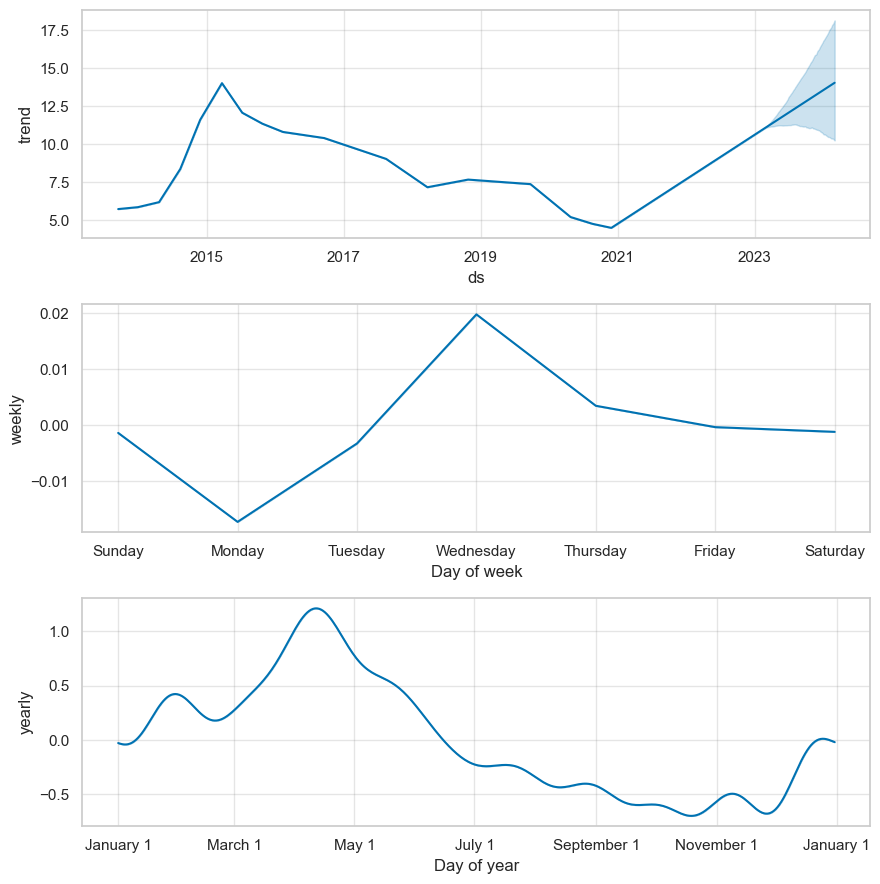

In [52]:
# Смотрим тренд, годовые и сезонные признаки
fig = final_test_model.plot_components(forecast)

c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


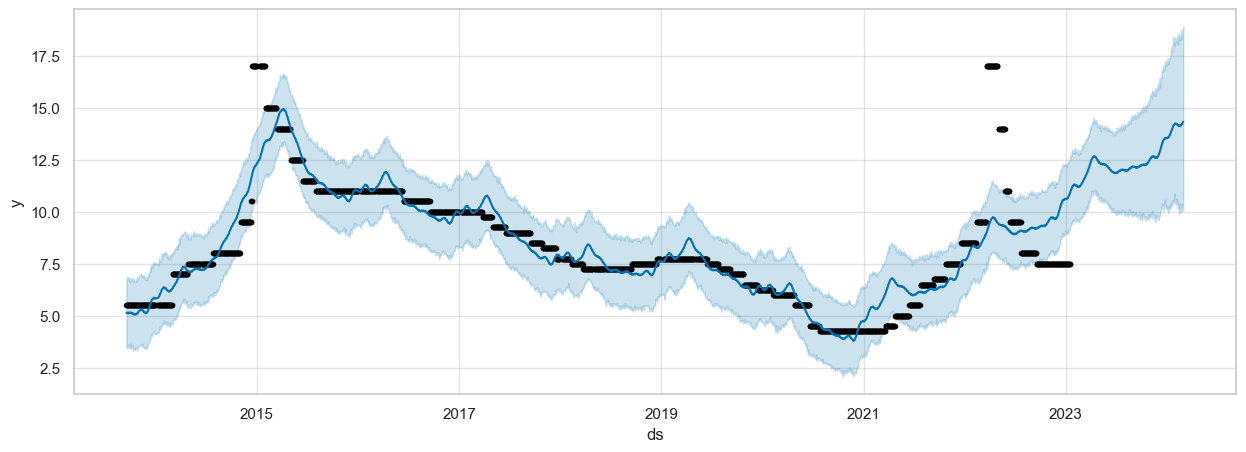

In [53]:
# Смотрим график прогноза после обучния на лучших параметрах
fig, ax = plt.subplots(1)
fig.set_figheight(5)
fig.set_figwidth(15)
fig = final_test_model.plot(forecast,ax=ax)
plt.show()

## Сравнение фактов и прогнозов

In [54]:
# Создание df с прогнозом
df_test_forecast_final = final_test_model.predict(df_test)
df_test_forecast_final[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
404,2024-08-22,15.043730,7.933181,21.619665
405,2024-08-23,15.051159,7.902593,21.526422
406,2024-08-26,15.063065,7.749701,21.870398
407,2024-08-27,15.084529,7.982860,22.151079
408,2024-08-28,15.113781,7.923856,21.753926


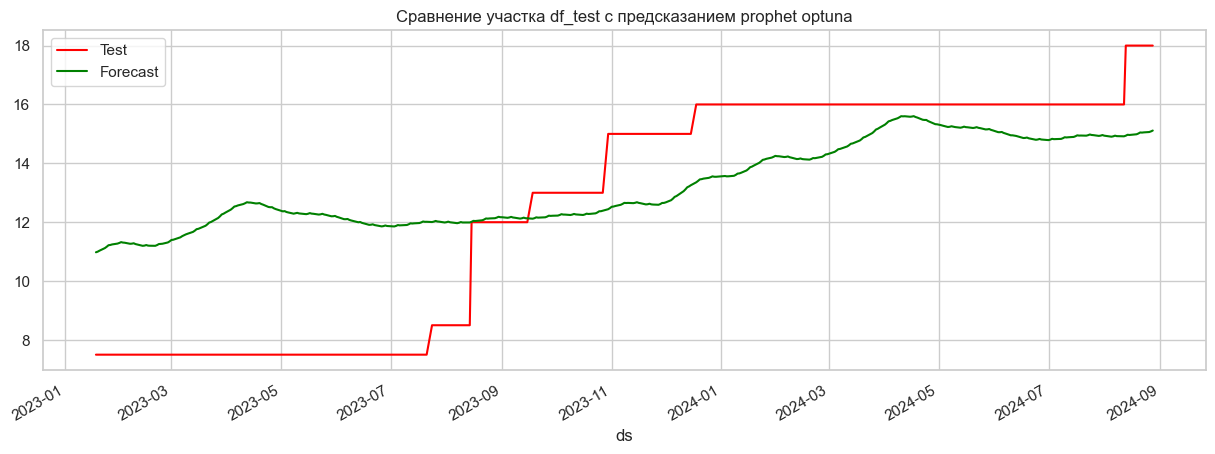

In [55]:
# Сравнение участка df_test с предсказанием prophet optuna
fig, ax = plt.subplots(figsize=(14,5))
fig.set_figheight(5)
fig.set_figwidth(15)
df_test.plot(kind='line',x='ds', y='y', color='red', label='Test', ax=ax)
df_test_forecast_final.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)
plt.title('Сравнение участка df_test с предсказанием prophet optuna')
plt.show()

In [56]:
# Сравниваем метрики после добавления в модель праздников 
metrics = pd.concat([metrics, get_metrics(y_test=df_test['y'], y_pred=df_test_forecast_final['yhat'], name='Prophet_best_params_optuna')])
metrics

,model,MAE,MAPE_%,MSE,RMSE
0,Prophet_baseline,2.448841,0.255418,8.082589,2.842989
0,Prophet_with_holidays,2.443749,0.255147,8.078405,2.842253
0,Prophet_best_params_optuna,2.386169,0.255847,8.237265,2.870064


# Обучение и прогнозирование курса ставки рефинансирования ЦБ РФ на полных данных

# Prophet baseline on df

In [66]:
# Обучение модели на df
prophet_bl = train_model(df)

02:50:25 - cmdstanpy - INFO - Chain [1] start processing
02:50:25 - cmdstanpy - INFO - Chain [1] done processing


In [58]:
# Создание df с прогнозом
future_bl = prophet_bl.make_future_dataframe(periods=config['train']['pred_days_forecast'], freq='D')
forecast_bl = prophet_bl.predict(future_bl)
forecast_bl[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2906,2025-02-20,17.541019,15.452766,19.548977
2907,2025-02-21,17.536265,15.461912,19.883978
2908,2025-02-22,18.295843,16.215752,20.436118
2909,2025-02-23,18.307411,16.157809,20.588856
2910,2025-02-24,17.557806,15.475331,19.740791


c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


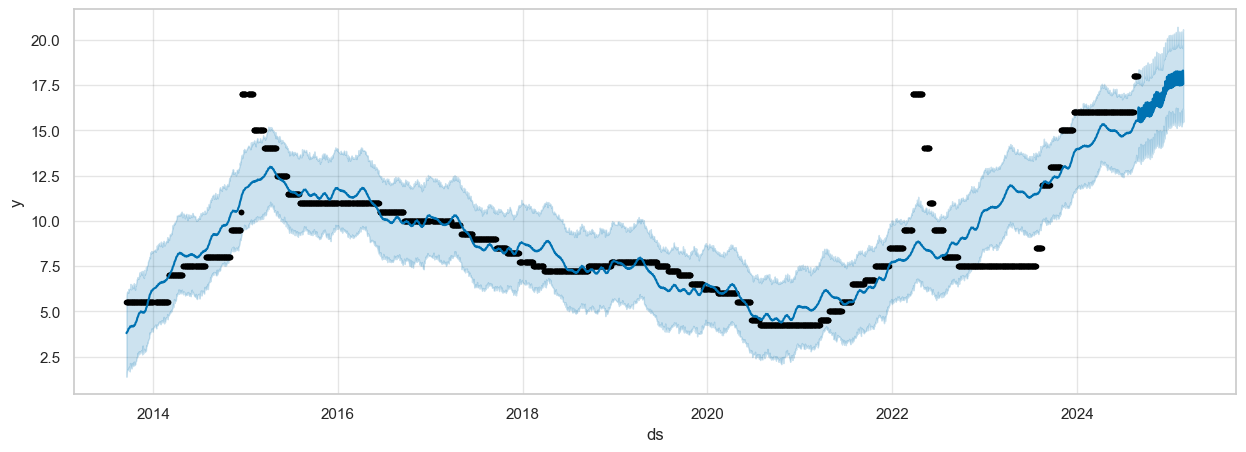

In [59]:
# Смотрим график прогноза
fig, ax = plt.subplots(1)
fig.set_figheight(5)
fig.set_figwidth(15)
fig = prophet_bl.plot(forecast_bl,ax=ax)
plt.show()

c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series cont

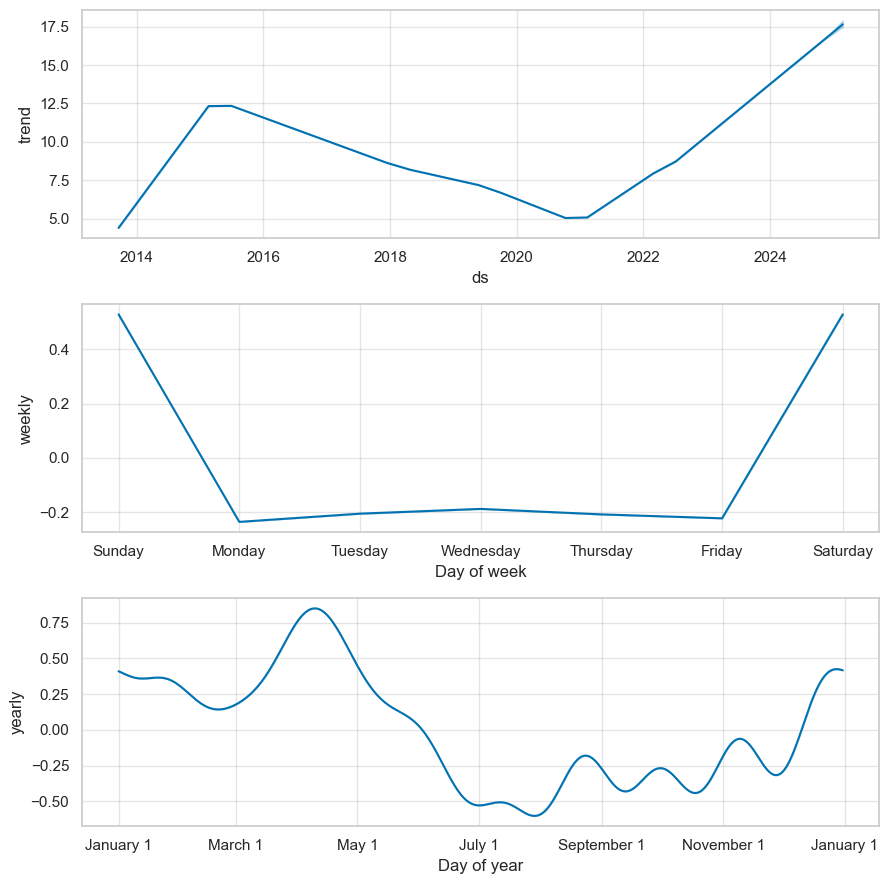

In [60]:
# Смотрим тренд, годовые и сезонные признаки
fig = prophet_bl.plot_components(forecast_bl)
plt.show()

# Prophet best params on df

In [67]:
# Обучение модели с лучшими параметрами на df
final_test_model = train_model(df, **prophet_best_params)

02:51:40 - cmdstanpy - INFO - Chain [1] start processing
02:51:41 - cmdstanpy - INFO - Chain [1] done processing


In [68]:
# Создание df с прогнозом
future_ftm = final_test_model.make_future_dataframe(periods=config['train']['pred_days_forecast'], freq='D')
forecast_ftm = final_test_model.predict(future_ftm)
forecast_ftm[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2906,2025-02-20,18.576462,16.184910,20.942867
2907,2025-02-21,18.579885,16.084045,21.076082
2908,2025-02-22,18.601383,16.191490,21.248452
2909,2025-02-23,18.622599,16.046836,21.233693
2910,2025-02-24,18.620362,16.127447,21.185801


c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


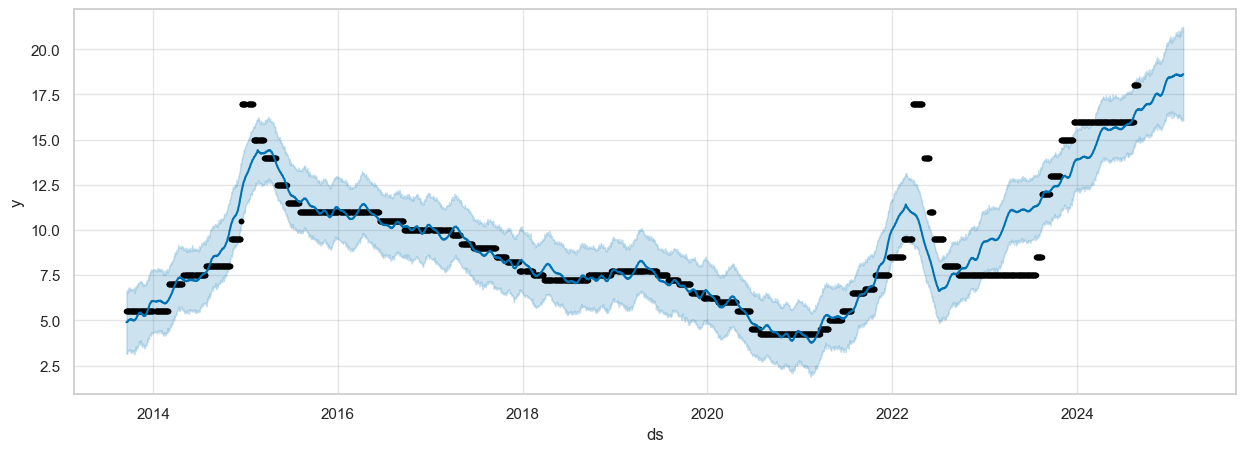

In [69]:
# Смотрим график прогноза
fig, ax = plt.subplots(1)
fig.set_figheight(5)
fig.set_figwidth(15)
fig = final_test_model.plot(forecast_ftm,ax=ax)
plt.show()

c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series cont

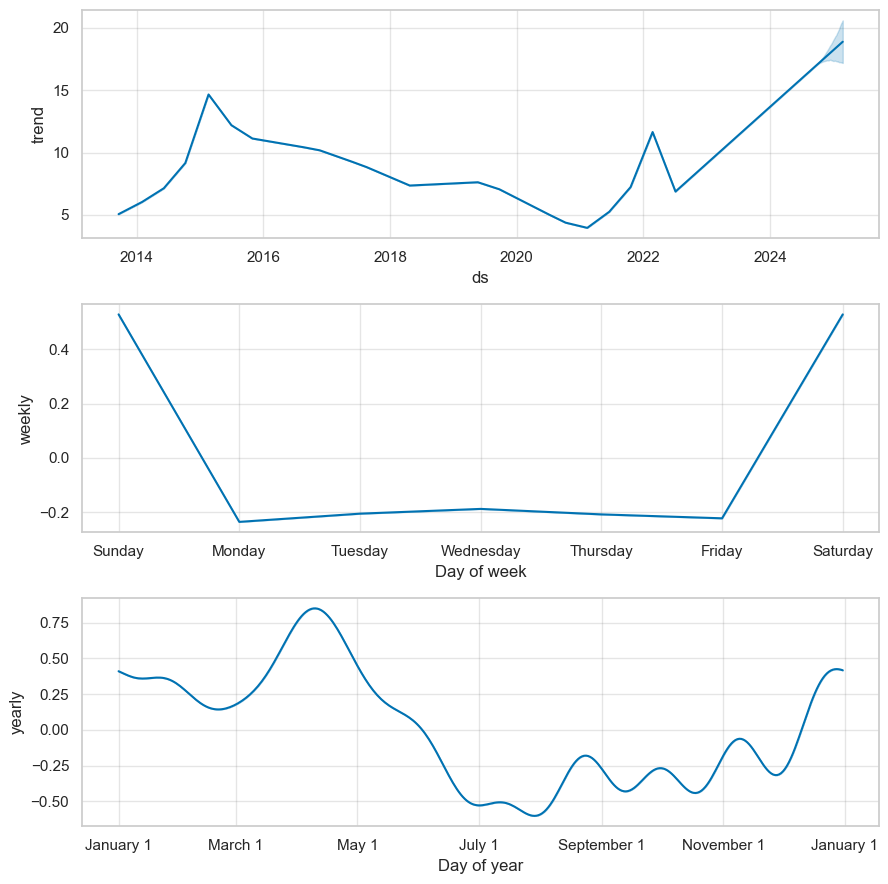

In [70]:
# Смотрим тренд, годовые и сезонные признаки
fig = prophet_bl.plot_components(forecast_ftm)
plt.show()

# Сравнение прогнозов обученных моделей

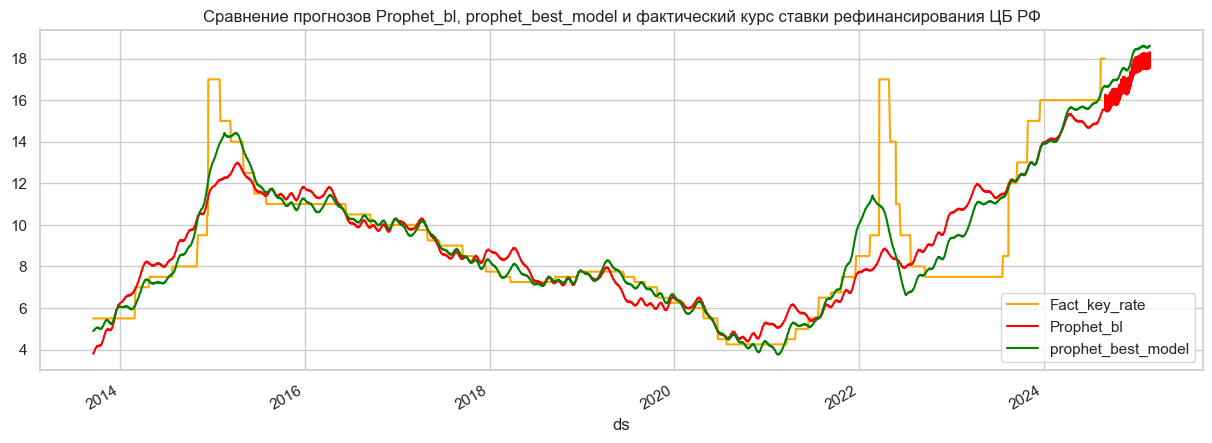

In [71]:
# Сравнение прогнозов Prophet_bl, prophet_best_model и фактический курс ставки рефинансирования ЦБ РФ
fig, ax = plt.subplots(figsize=(14,5))
fig.set_figheight(5)
fig.set_figwidth(15)
df.plot(kind='line',x='ds', y='y', color='orange', label='Fact_key_rate', ax=ax)
forecast_bl.plot(kind='line', x='ds', y='yhat', color='red', label='Prophet_bl', ax=ax)
forecast_ftm.plot(kind='line', x='ds', y='yhat', color='green', label='prophet_best_model', ax=ax)
plt.title('Сравнение прогнозов Prophet_bl, prophet_best_model и фактический курс ставки рефинансирования ЦБ РФ')
plt.show()